<a href="https://colab.research.google.com/github/jceltruda/FinGPT-TransformerPrediction/blob/Yash/Llama_Finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# You only need to run this once per machine
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets matplotlib
!pip install jsonlines

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 9.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 7.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 103.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [2]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

In [3]:
from datetime import datetime, timedelta
import yfinance as yf
import json
from google.colab import drive


# Fetching the data
ticker = "^DJI"  # Ticker symbol for Dow Jones Industrial Average
# Mount your Google Drive
from google.colab import drive
drive.mount("/content/drive")

# Change directory to where the file is saved
#%cd /content/drive/MyDrive

# Read the data from the file
import pandas as pd
data = yf.download(ticker, start="2023-01-01", end="2023-12-31")  # Example: Data for 2023

# data = pd.read_csv("data.csv")
print(data)



import json
import jsonlines

# Step 1: Download the data
# data = yf.download(tickers='GOOG', period='5d', interval='1m')

# Step 2: Convert the data to a list of dictionaries
data_list = data.to_dict('records')
#print(data_list)
# Step 3: Write the data to a .jsonl file
with open('data.jsonl', 'w') as f:
    for item in data_list:
        json.dump(item, f)
        f.write('\n')


"""
Credit for the following code is used from my partner Ethan Zhang that I am using for testing inputting into the model
"""
end_date = datetime.now().date()
start_date = end_date - timedelta(days=2*365)
# Fetch the DJIA stock data
djia_data = yf.download(ticker, start=start_date, end=end_date)

# Convert the DataFrame to a list of dictionaries
djia_records = djia_data.reset_index().to_dict('records')
output_file = "djia_stock_data.jsonl"
with open(output_file, 'w') as f:
    pass

for i in range(7, len(djia_records)):
    input_days = djia_records[i-7:i]
    output_day = djia_records[i]

    # make each input a string and each output a string with the following format:
    # input:
    # "Market Values for previous 6 days:
    # Day 1: Open:{open} High:{high} Low:{low} Close:{close} Adj Close:{adj close} Volume:{volume}, ...
    # Day 6: Open:{open} High:{high} Low:{low} Close:{close} Adj Close:{adj close} Volume:{volume}."
    # output: "Today's Market Values: Open:{open} High:{high} Low:{low} Close:{close} Adj Close:{adj close} Volume:{volume}"
    input_str = "Market Values for previous 6 days:"
    for j in range(6):
        input_str += (
            f"Day {j+1}: Open:{input_days[j]['Open']} High:{input_days[j]['High']} "
            f"Low:{input_days[j]['Low']} Close:{input_days[j]['Close']} Adj "
            f"Close:{input_days[j]['Adj Close']} Volume:{input_days[j]['Volume']}, "
            if j != 5 else
            f"Day {j+1}: Open:{input_days[j]['Open']} High:{input_days[j]['High']} "
            f"Low:{input_days[j]['Low']} Close:{input_days[j]['Close']} Adj "
            f"Close:{input_days[j]['Adj Close']} Volume:{input_days[j]['Volume']}."
        )

    output_str = (
        f"Today's Market Values: Open:{output_day['Open']} High:{output_day['High']} "
        f"Low:{output_day['Low']} Close:{output_day['Close']} Adj "
        f"Close:{output_day['Adj Close']} Volume:{output_day['Volume']}"
    )

    # create a new record with the input and output strings
    record = {"input": input_str, "output": output_str}

    # print(str(record) + "\n")

    # write the record to the JSON Lines file
    with jsonlines.open(output_file, mode='a') as writer:
        writer.write(record)


from datasets import load_dataset

train_dataset = load_dataset('json', data_files='djia_stock_data.jsonl', split='train')
eval_dataset = load_dataset('json', data_files='djia_stock_data.jsonl', split='train')


# Converting to JSON Lines format and saving to a file
# with open(data, 'w') as file:
#     for date, row in data.iterrows():
#         # Creating a dictionary for each record
#         record = {
#             "Date": str(date.date()),
#             "Open": row['Open'],
#             "High": row['High'],
#             "Low": row['Low'],
#             "Close": row['Close'],
#             "Adj Close": row['Adj Close'],
#             "Volume": row['Volume']
#         }
#         # Writing the JSON object to the file followed by a newline character
#         file.write(json.dumps(record) + '\n')

# print("Data saved to DJIA_data.jsonl")







Mounted at /content/drive


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


                    Open          High           Low         Close  \
Date                                                                 
2023-01-03  33148.898438  33387.519531  32850.570312  33136.371094   
2023-01-04  33165.140625  33409.101562  33033.480469  33269.769531   
2023-01-05  33191.718750  33191.718750  32812.328125  32930.078125   
2023-01-06  33055.300781  33710.660156  32997.390625  33630.609375   
2023-01-09  33664.390625  33935.109375  33487.660156  33517.648438   
...                  ...           ...           ...           ...   
2023-12-22  37349.269531  37534.519531  37268.878906  37385.968750   
2023-12-26  37405.898438  37617.988281  37371.828125  37545.328125   
2023-12-27  37518.621094  37683.699219  37488.601562  37656.519531   
2023-12-28  37661.519531  37778.851562  37650.980469  37710.101562   
2023-12-29  37701.628906  37759.429688  37538.800781  37689.539062   

               Adj Close     Volume  
Date                                 
2023-01-03  3

Generating train split: 0 examples [00:00, ? examples/s]

In [4]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) N
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [5]:
from transformers import AutoTokenizer

model = "google/gemma-7b"
tokenizer = AutoTokenizer.from_pretrained(model, use_auth_token=True)

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/tokenization_auto.py:721: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/555 [00:00<?, ?B/s]

In [6]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "google/gemma-7b"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config)

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/2.11G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [7]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def formatting_func(example):
    print(example)
    text = f"### Input data: {example['input']}\n ### Output data: {example['output']}"
    return text


def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

In [8]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/494 [00:00<?, ? examples/s]

{'input': 'Market Values for previous 6 days:Day 1: Open:33655.4296875 High:33655.4296875 Low:33254.12109375 Close:33614.80078125 Adj Close:33614.80078125 Volume:408390000, Day 2: Open:33579.75 High:33579.75 Low:32806.1484375 Close:32817.37890625 Adj Close:32817.37890625 Volume:488400000, Day 3: Open:32885.171875 High:33402.98046875 Low:32578.73046875 Close:32632.640625 Adj Close:32632.640625 Volume:553750000, Day 4: Open:32860.421875 High:33457.28125 Low:32860.421875 Close:33286.25 Adj Close:33286.25 Volume:418670000, Day 5: Open:33106.76953125 High:33236.58984375 Low:32819.76171875 Close:33174.0703125 Adj Close:33174.0703125 Volume:399480000, Day 6: Open:33279.71875 High:33515.609375 Low:32911.890625 Close:32944.19140625 Adj Close:32944.19140625 Volume:369480000.', 'output': "Today's Market Values: Open:32989.26953125 High:33620.83984375 Low:32989.26953125 Close:33544.33984375 Adj Close:33544.33984375 Volume:388810000"}
{'input': 'Market Values for previous 6 days:Day 1: Open:33579.7

In [9]:
max_length = 512 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/494 [00:00<?, ? examples/s]

{'input': 'Market Values for previous 6 days:Day 1: Open:33655.4296875 High:33655.4296875 Low:33254.12109375 Close:33614.80078125 Adj Close:33614.80078125 Volume:408390000, Day 2: Open:33579.75 High:33579.75 Low:32806.1484375 Close:32817.37890625 Adj Close:32817.37890625 Volume:488400000, Day 3: Open:32885.171875 High:33402.98046875 Low:32578.73046875 Close:32632.640625 Adj Close:32632.640625 Volume:553750000, Day 4: Open:32860.421875 High:33457.28125 Low:32860.421875 Close:33286.25 Adj Close:33286.25 Volume:418670000, Day 5: Open:33106.76953125 High:33236.58984375 Low:32819.76171875 Close:33174.0703125 Adj Close:33174.0703125 Volume:399480000, Day 6: Open:33279.71875 High:33515.609375 Low:32911.890625 Close:32944.19140625 Adj Close:32944.19140625 Volume:369480000.', 'output': "Today's Market Values: Open:32989.26953125 High:33620.83984375 Low:32989.26953125 Close:33544.33984375 Adj Close:33544.33984375 Volume:388810000"}
{'input': 'Market Values for previous 6 days:Day 1: Open:33579.7

Map:   0%|          | 0/494 [00:00<?, ? examples/s]

{'input': 'Market Values for previous 6 days:Day 1: Open:33655.4296875 High:33655.4296875 Low:33254.12109375 Close:33614.80078125 Adj Close:33614.80078125 Volume:408390000, Day 2: Open:33579.75 High:33579.75 Low:32806.1484375 Close:32817.37890625 Adj Close:32817.37890625 Volume:488400000, Day 3: Open:32885.171875 High:33402.98046875 Low:32578.73046875 Close:32632.640625 Adj Close:32632.640625 Volume:553750000, Day 4: Open:32860.421875 High:33457.28125 Low:32860.421875 Close:33286.25 Adj Close:33286.25 Volume:418670000, Day 5: Open:33106.76953125 High:33236.58984375 Low:32819.76171875 Close:33174.0703125 Adj Close:33174.0703125 Volume:399480000, Day 6: Open:33279.71875 High:33515.609375 Low:32911.890625 Close:32944.19140625 Adj Close:32944.19140625 Volume:369480000.', 'output': "Today's Market Values: Open:32989.26953125 High:33620.83984375 Low:32989.26953125 Close:33544.33984375 Adj Close:33544.33984375 Volume:388810000"}
{'input': 'Market Values for previous 6 days:Day 1: Open:33579.7

988


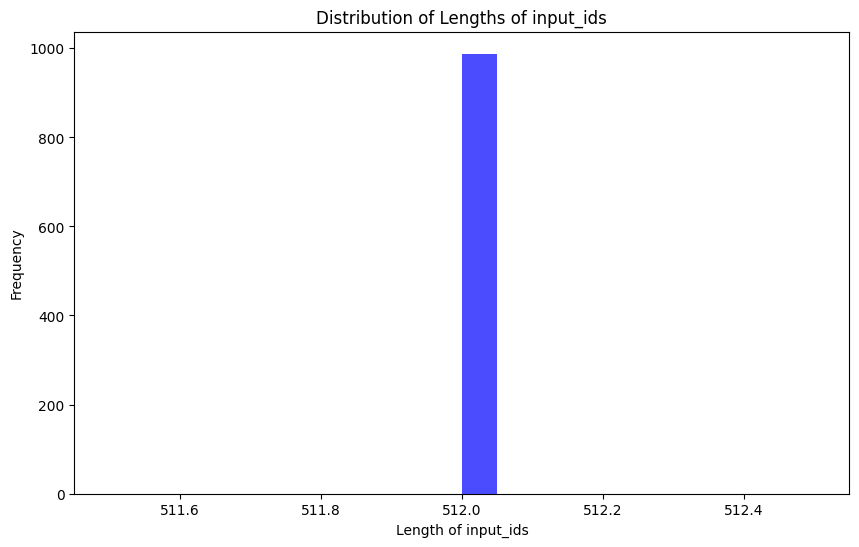

In [10]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenize_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [11]:
eval_prompt = """ Given the following financial input data, predict the output data for the closing numbers of that day

### Financial Input Data:
Market Values for previous 6 days:
Day 1: Open:33710.69921875 High:33954.7109375 Low:33582.9609375 Close:33912.44140625 Adj Close:33912.44140625 Volume:262670000,
Day 2: Open:33924.3515625 High:34281.359375 Low:33852.5703125 Close:34152.01171875 Adj Close:34152.01171875 Volume:288670000,
Day 3: Open:34029.55078125 High:34161.01171875 Low:33828.41015625 Close:33980.3203125 Adj Close:33980.3203125 Volume:281390000,
Day 4: Open:33981.859375 High:34043.828125 Low:33844.4609375 Close:33999.0390625 Adj Close:33999.0390625 Volume:282550000,
Day 5: Open:33904.69140625 High:33904.69140625 Low:33627.08984375 Close:33706.73828125 Adj Close:33706.73828125 Volume:293990000,
Day 6: Open:33586.58984375 High:33586.58984375 Low:33007.62890625 Close:33063.609375 Adj Close:33063.609375 Volume:308900000."

### Output Data:
"""

model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(tokenizer.decode(model.generate(**model_input, max_new_tokens=256, pad_token_id=2)[0], skip_special_tokens=True))

 Given the following financial input data, predict the output data for the closing numbers of that day

### Financial Input Data:
Market Values for previous 6 days:
Day 1: Open:33710.69921875 High:33954.7109375 Low:33582.9609375 Close:33912.44140625 Adj Close:33912.44140625 Volume:262670000,
Day 2: Open:33924.3515625 High:34281.359375 Low:33852.5703125 Close:34152.01171875 Adj Close:34152.01171875 Volume:288670000,
Day 3: Open:34029.55078125 High:34161.01171875 Low:33828.41015625 Close:33980.3203125 Adj Close:33980.3203125 Volume:281390000,
Day 4: Open:33981.859375 High:34043.828125 Low:33844.4609375 Close:33999.0390625 Adj Close:33999.0390625 Volume:282550000,
Day 5: Open:33904.69140625 High:33904.69140625 Low:33627.08984375 Close:33706.73828125 Adj Close:33706.73828125 Volume:293990000,
Day 6: Open:33586.58984375 High:33586.58984375 Low:33007.62890625 Close:33063.609375 Adj Close:33063.609375 Volume:308900000."

### Output Data:



In [12]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [13]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

print(model)


GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 3072, padding_idx=0)
    (layers): ModuleList(
      (0-27): 28 x GemmaDecoderLayer(
        (self_attn): GemmaAttention(
          (q_proj): Linear4bit(in_features=3072, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=3072, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=3072, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=3072, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear4bit(in_features=3072, out_features=24576, bias=False)
          (up_proj): Linear4bit(in_features=3072, out_features=24576, bias=False)
          (down_proj): Linear4bit(in_features=24576, out_features=3072, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )

In [14]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

print(model)

trainable params: 108298240 || all params: 4770442240 || trainable%: 2.2701928783860508
PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): GemmaForCausalLM(
      (model): GemmaModel(
        (embed_tokens): Embedding(256000, 3072, padding_idx=0)
        (layers): ModuleList(
          (0-27): 28 x GemmaDecoderLayer(
            (self_attn): GemmaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=3072, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=3072, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterD

1


In [15]:
import torch

# Print the PyTorch version
print(torch.__version__)

2.1.0+cu121


In [19]:
import transformers
from datetime import datetime

project = "journal-finetune"
base_model_name = "google/gemma-7b"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

tokenizer.pad_token = tokenizer.eos_token

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        max_steps=400,
        learning_rate=2.5e-4, # Want a small lr for finetuning
        fp16=True,
        optim="paged_adamw_8bit",
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=50,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=50,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        #report_to="wandb",           # Comment this out if you don't want to use weights & baises
        #run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.46 GiB. GPU 0 has a total capacty of 14.75 GiB of which 69.06 MiB is free. Process 2252 has 14.42 GiB memory in use. Of the allocated memory 12.55 GiB is allocated by PyTorch, and 1.74 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "google/gemma-7b"

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Llama 2 7B, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True
)

tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "llama2-7b-journal-finetune/checkpoint-500")

config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

In [ ]:
eval_prompt = """ Given the following financial input data, predict the output data for the closing numbers of that day

### Financial Input Data:
Market Values for previous 6 days:
Day 1: Open:33710.69921875 High:33954.7109375 Low:33582.9609375 Close:33912.44140625 Adj Close:33912.44140625 Volume:262670000,
Day 2: Open:33924.3515625 High:34281.359375 Low:33852.5703125 Close:34152.01171875 Adj Close:34152.01171875 Volume:288670000,
Day 3: Open:34029.55078125 High:34161.01171875 Low:33828.41015625 Close:33980.3203125 Adj Close:33980.3203125 Volume:281390000,
Day 4: Open:33981.859375 High:34043.828125 Low:33844.4609375 Close:33999.0390625 Adj Close:33999.0390625 Volume:282550000,
Day 5: Open:33904.69140625 High:33904.69140625 Low:33627.08984375 Close:33706.73828125 Adj Close:33706.73828125 Volume:293990000,
Day 6: Open:33586.58984375 High:33586.58984375 Low:33007.62890625 Close:33063.609375 Adj Close:33063.609375 Volume:308900000."

### Output Data:
"""
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=300)[0], skip_special_tokens=True))